# 03 · Neural Network (PyTorch)

Implements the prescribed `64→128→64→2` dense network so the ML model mimics the RK4 + shooting solver while respecting the FPF cleaning rules.

In [1]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

DATA_DIR = Path("../data/processed")
TRAIN_PATH = DATA_DIR / "train_dataset.csv"
TEST_PATH = DATA_DIR / "test_dataset.csv"
ARTIFACT_DIR = Path("../models")
FEATURES = ["M", "S", "K", "phi1", "phi2", "Ec", "Pr", "eta"]
TARGETS = ["f3", "f5"]
RANDOM_STATE = 42
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
device = torch.device("cpu")
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

## Load and split data

In [2]:
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)
X_full = train_df[FEATURES].to_numpy(dtype=float)
y_full = train_df[TARGETS].to_numpy(dtype=float)
X_test = test_df[FEATURES].to_numpy(dtype=float)
y_test = test_df[TARGETS].to_numpy(dtype=float)
X_train, X_val, y_train, y_val = train_test_split(
    X_full,
    y_full,
    test_size=0.2,
    random_state=RANDOM_STATE,
    shuffle=True,
)
X_train.shape, X_val.shape, X_test.shape

((107, 8), (27, 8), (34, 8))

## Normalize features (physics order preserved)

In [3]:
feature_mean = X_train.mean(axis=0)
feature_std = X_train.std(axis=0) + 1e-8

def scale(features):
    return (features - feature_mean) / feature_std

X_train_s = scale(X_train)
X_val_s = scale(X_val)
X_test_s = scale(X_test)
feature_mean, feature_std

(array([9.90654206e-01, 1.00804998e+00, 1.00467290e+00, 2.00000000e-02,
        1.22429907e-02, 5.62616822e-01, 2.03214953e+02, 1.32089720e+00]),
 array([1.80618216e-01, 1.28073761e-01, 1.44935173e-01, 3.61720673e-03,
        5.84990995e-03, 3.64171933e-01, 1.81556243e+01, 8.70996721e-01]))

## Torch dataset/dataloader

In [4]:
class GradientDataset(Dataset):
    def __init__(self, inputs, targets):
        self.X = torch.tensor(inputs, dtype=torch.float32)
        self.y = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

BATCH_SIZE = 32
train_loader = DataLoader(GradientDataset(X_train_s, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(GradientDataset(X_val_s, y_val), batch_size=BATCH_SIZE, shuffle=False)
test_dataset = GradientDataset(X_test_s, y_test)
len(train_loader), len(val_loader)

(4, 1)

## Model definition

In [5]:
class GradientNet(nn.Module):
    def __init__(self, in_features=8, hidden1=64, hidden2=128, hidden3=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, hidden3),
            nn.ReLU(),
            nn.Linear(hidden3, 2),
        )

    def forward(self, x):
        return self.net(x)

model = GradientNet().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model

GradientNet(
  (net): Sequential(
    (0): Linear(in_features=8, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=2, bias=True)
  )
)

## Training loop with early stopping

In [6]:
EPOCHS = 500
PATIENCE = 40

history = []
best_val = float("inf")
best_state = None
patience_counter = 0

def run_epoch(loader, train=True):
    total_loss = 0.0
    total_samples = 0
    if train:
        model.train()
    else:
        model.eval()
    with torch.set_grad_enabled(train):
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            total_loss += loss.item() * xb.size(0)
            total_samples += xb.size(0)
    return total_loss / max(1, total_samples)

for epoch in range(1, EPOCHS + 1):
    train_loss = run_epoch(train_loader, train=True)
    val_loss = run_epoch(val_loader, train=False)
    history.append({"epoch": epoch, "train_loss": train_loss, "val_loss": val_loss})
    if val_loss < best_val - 1e-6:
        best_val = val_loss
        best_state = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
    if patience_counter >= PATIENCE:
        print(f"Early stopping at epoch {epoch}")
        break
len(history)

Early stopping at epoch 50


50

## Restore best weights and evaluate

In [7]:
model.load_state_dict(best_state)
model.eval()

def predict(dataset):
    loader = DataLoader(dataset, batch_size=64, shuffle=False)
    outputs = []
    with torch.no_grad():
        for xb, _ in loader:
            xb = xb.to(device)
            preds = model(xb)
            outputs.append(preds.cpu().numpy())
    return np.vstack(outputs)

test_preds = predict(test_dataset)
metrics = {}
for idx, target in enumerate(TARGETS):
    metrics[f"{target}_MAE"] = mean_absolute_error(y_test[:, idx], test_preds[:, idx])
    metrics[f"{target}_RMSE"] = mean_squared_error(y_test[:, idx], test_preds[:, idx]) ** 0.5
    metrics[f"{target}_R2"] = r2_score(y_test[:, idx], test_preds[:, idx])
metrics

{'f3_MAE': 0.1837321653332807,
 'f3_RMSE': 0.23782652980347754,
 'f3_R2': 0.39410152210565486,
 'f5_MAE': 1.0681822824086014,
 'f5_RMSE': 1.8754498663571204,
 'f5_R2': 0.31307476353395736}

## Plot learning curves

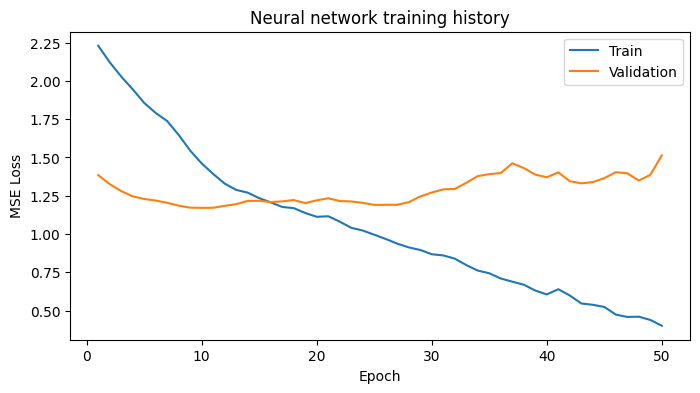

In [8]:
import matplotlib.pyplot as plt

epochs = [row["epoch"] for row in history]
train_losses = [row["train_loss"] for row in history]
val_losses = [row["val_loss"] for row in history]
plt.figure(figsize=(8, 4))
plt.plot(epochs, train_losses, label="Train")
plt.plot(epochs, val_losses, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Neural network training history")
plt.show()

## Persist artifacts

In [9]:
model_path = ARTIFACT_DIR / "neural_network.pt"
metadata_path = ARTIFACT_DIR / "neural_network_metadata.json"
torch.save({"state_dict": model.state_dict(), "feature_mean": feature_mean.tolist(), "feature_std": feature_std.tolist()}, model_path)
with metadata_path.open("w", encoding="utf-8") as f:
    json.dump({
        "feature_mean": feature_mean.tolist(),
        "feature_std": feature_std.tolist(),
        "metrics": metrics,
        "history": history,
    }, f, indent=2)
model_path, metadata_path

(WindowsPath('../models/neural_network.pt'),
 WindowsPath('../models/neural_network_metadata.json'))